In [1]:
#!pip install yfinance ta pyfolio empyrical

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import os
import warnings
import ta
import empyrical as em

# Ignore printing all warnings
warnings.filterwarnings('ignore')

In [3]:
# downloading historical necessary data for backtesting and analysis
_start = dt.date(2011,1,1)
_end = dt.date.today()
ticker = 'TORNTPOWER.NS'
df = yf.download(ticker, start = _start, end = _end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,276.000000,281.000000,275.149994,276.200012,211.723206,40361
2011-01-04,277.000000,280.399994,273.500000,274.450012,210.381760,59006
2011-01-05,275.100006,277.500000,270.149994,271.950012,208.465363,58289


In [5]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-13,1132.949951,1147.750000,1108.949951,1119.349976,1108.234741,454176
2024-02-14,1117.000000,1162.949951,1056.949951,1130.800049,1119.571167,809686
2024-02-15,1134.000000,1236.949951,1134.000000,1208.449951,1196.449951,2399731


In [6]:
df.dropna(inplace = True)

In [7]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2011-01-03,276.000000,281.000000,275.149994,276.200012,211.723206,40361,NaN
2011-01-04,277.000000,280.399994,273.500000,274.450012,210.381760,59006,-0.006356
2011-01-05,275.100006,277.500000,270.149994,271.950012,208.465363,58289,-0.009151


In [8]:
# creating SMA and EMA short and long indicators
short = 10 # Short Period
long = 50 # Long Period
df['SMA_Short'] = ta.trend.SMAIndicator(df['Close'],window=short).sma_indicator()
df['SMA_Long'] = ta.trend.SMAIndicator(df['Close'],window=long).sma_indicator()
df['EMA_Short'] = ta.trend.EMAIndicator(df['Close'],window=short).ema_indicator()
df['EMA_Long'] = ta.trend.EMAIndicator(df['Close'],window=long).ema_indicator()
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long
Date,,,,,,,,
2024-02-09,1173.449951,1161.797485,1223641,-0.025950,1098.175006,989.358998,1115.449211,987.483517
2024-02-12,1130.500000,1119.274048,364493,-0.037288,1110.840009,993.140997,1118.185718,993.092007
2024-02-13,1119.349976,1108.234741,454176,-0.009912,1121.980005,996.247997,1118.397401,998.043300
2024-02-14,1130.800049,1119.571167,809686,0.010177,1131.060010,999.814998,1120.652428,1003.249447
2024-02-15,1208.449951,1196.449951,2399731,0.066413,1146.735010,1004.637997,1136.615614,1011.296526


<Axes: xlabel='Date'>

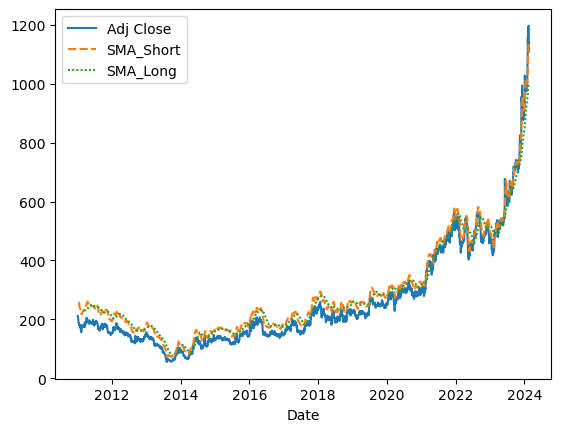

In [9]:
import seaborn as sns
sns.lineplot(df[['Adj Close','SMA_Short','SMA_Long']])


<Axes: xlabel='Date'>

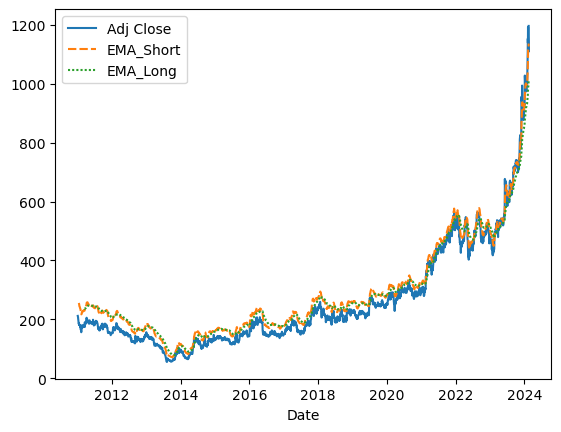

In [10]:
sns.lineplot(df[['Adj Close','EMA_Short','EMA_Long']])

In [11]:
# SMA Cross over Strategy 

# Position Strategy
# BUY condition
df['sma_signal'] = np.where((df['SMA_Short'] > df['SMA_Long']),1,np.nan)
# SELL condition
df['sma_signal'] = np.where( (df['SMA_Short'] < df['SMA_Long']),0,df['sma_signal'])

# Margin Trading Strategy
#df['sma_signal'] = np.where((df['SMA_Short'] > df['SMA_Long']),1,-1)

# creating long and short positions
df['sma_position'] = df['sma_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df['sma_position'] = df['sma_position'].shift(1)

# calculating stretegy returns
df['sma_strategy_returns'] = df['bnh_returns'] * (df['sma_position'])

df.tail(10)


,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long,sma_signal,sma_position,sma_strategy_returns
Date,,,,,,,,,,,
2024-02-02,1064.300049,1053.731445,512473,0.011909,1013.879993,954.379996,1024.406249,948.411945,1.0,1.0,0.011909
2024-02-05,1121.050049,1109.917969,914432,0.051948,1026.275000,960.379998,1041.977849,955.182067,1.0,1.0,0.051948
2024-02-06,1164.849976,1153.282959,831483,0.038327,1043.864996,967.741997,1064.318236,963.404338,1.0,1.0,0.038327
2024-02-07,1150.300049,1138.877441,894803,-0.012570,1060.485004,975.004998,1079.951293,970.733582,1.0,1.0,-0.012570
2024-02-08,1204.300049,1192.341309,469436,0.045876,1080.910010,982.770999,1102.560157,979.893051,1.0,1.0,0.045876
2024-02-09,1173.449951,1161.797485,1223641,-0.025950,1098.175006,989.358998,1115.449211,987.483517,1.0,1.0,-0.025950
2024-02-12,1130.500000,1119.274048,364493,-0.037288,1110.840009,993.140997,1118.185718,993.092007,1.0,1.0,-0.037288
2024-02-13,1119.349976,1108.234741,454176,-0.009912,1121.980005,996.247997,1118.397401,998.043300,1.0,1.0,-0.009912
2024-02-14,1130.800049,1119.571167,809686,0.010177,1131.060010,999.814998,1120.652428,1003.249447,1.0,1.0,0.010177


In [12]:
# EMA Cross over Strategy

# BUY condition
df['ema_signal'] = np.where( (df['EMA_Short'] > df['EMA_Long']),1,np.nan)

# SELL condition
df['ema_signal'] = np.where( (df['EMA_Short'] < df['EMA_Long']),0,df['ema_signal'])
# creating long and short positions
df['ema_position'] = df['ema_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df['ema_position'] = df['ema_position'].shift(1)

# calculating stretegy returns
df['ema_strategy_returns'] = df['bnh_returns'] * (df['ema_position'])

df.sample(10)

,Close,Adj Close,Volume,bnh_returns,SMA_Short,SMA_Long,EMA_Short,EMA_Long,sma_signal,sma_position,sma_strategy_returns,ema_signal,ema_position,ema_strategy_returns
Date,,,,,,,,,,,,,,
2016-01-12,219.699997,180.967957,815319,-0.021390,204.135002,187.032000,208.275714,187.511601,1.0,1.0,-0.021390,1.0,1.0,-0.021390
2022-08-23,580.849976,557.229248,673814,-0.004638,572.779999,505.135999,571.484575,520.949772,1.0,1.0,-0.004638,1.0,1.0,-0.004638
2021-04-13,397.000000,369.667419,1039223,-0.007528,417.079999,384.374999,413.195296,390.951144,1.0,1.0,-0.007528,1.0,1.0,-0.007528
2016-09-02,181.899994,152.693726,212080,-0.014192,186.189999,177.355999,185.419315,182.656908,1.0,1.0,-0.014192,1.0,1.0,-0.014192
2018-09-26,229.550003,198.712723,885761,0.006118,238.070000,239.393000,237.094064,241.474279,0.0,1.0,0.006118,0.0,0.0,0.000000
2019-12-09,275.049988,243.010620,808510,0.013728,277.100000,283.426000,277.259704,282.422786,0.0,0.0,0.000000,0.0,0.0,0.000000
2014-02-28,83.349998,67.746674,118797,0.004810,85.075000,101.614000,85.641884,96.516089,0.0,0.0,0.000000,0.0,0.0,0.000000
2014-08-12,127.750000,104.146065,420012,0.022162,132.640001,150.949001,132.186774,141.866549,0.0,0.0,0.000000,0.0,0.0,0.000000
2019-01-01,259.500000,224.639282,537488,-0.008824,259.915001,255.109001,259.374661,255.008285,1.0,1.0,-0.008824,1.0,1.0,-0.008824


In [13]:
df['ema_strategy_returns'].describe()

count    3186.000000
mean        0.000411
std         0.018144
min        -0.160143
25%        -0.002802
50%         0.000000
75%         0.001741
max         0.173805
Name: ema_strategy_returns, dtype: float64

In [14]:
df['sma_strategy_returns'].describe()

count    3186.000000
mean        0.000350
std         0.017819
min        -0.160143
25%        -0.002919
50%         0.000000
75%         0.001350
max         0.173805
Name: sma_strategy_returns, dtype: float64

Buy and hold returns: 1.7318342896460492
SMA_Strategy returns: 1.11444682974763
EMA_Strategy returns: 1.3084742695414715


<Axes: xlabel='Date'>

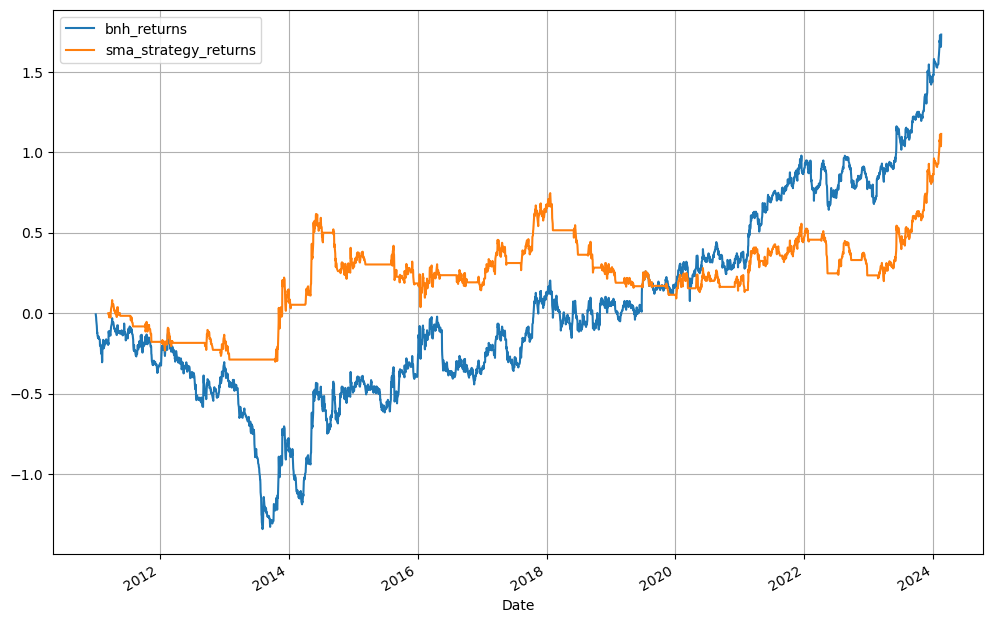

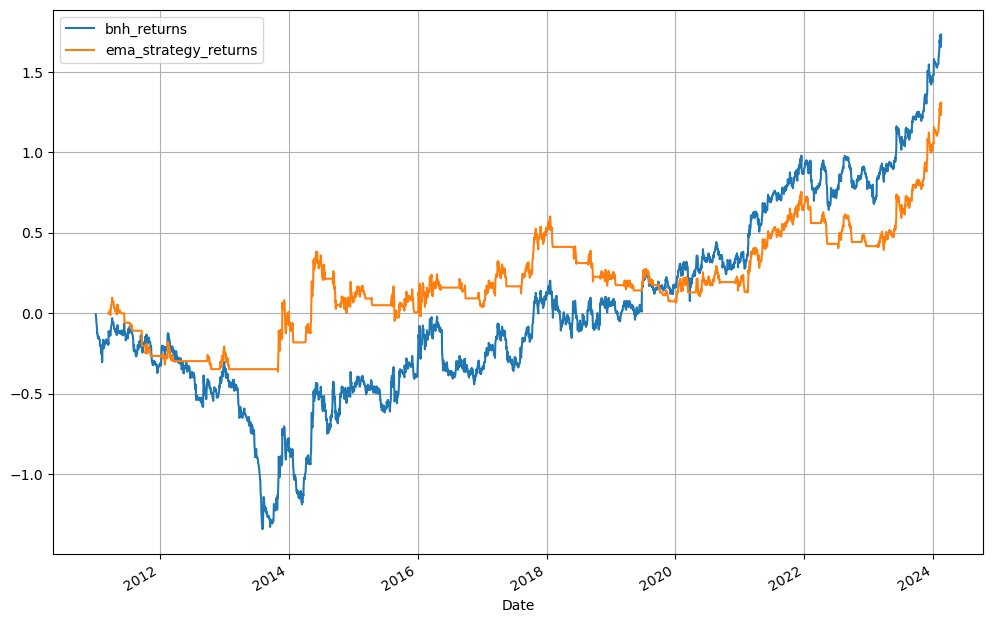

In [15]:
# comparing buy & hold strategy / MA crosover strategy
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("SMA_Strategy returns:",df['sma_strategy_returns'].cumsum()[-1])
print("EMA_Strategy returns:",df['ema_strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','sma_strategy_returns']].cumsum().plot(grid=True, figsize=(12, 8))

# plotting strategy historical performance over time
df[['bnh_returns','ema_strategy_returns']].cumsum().plot(grid=True, figsize=(12, 8))

Start date,2011-01-03
End date,2024-02-15
Total months,154
,Backtest
Annual return,6.9%
Cumulative returns,134.2%
Annual volatility,37.3%
Sharpe ratio,0.36
Calmar ratio,0.09
Stability,0.35
Max drawdown,-77.0%


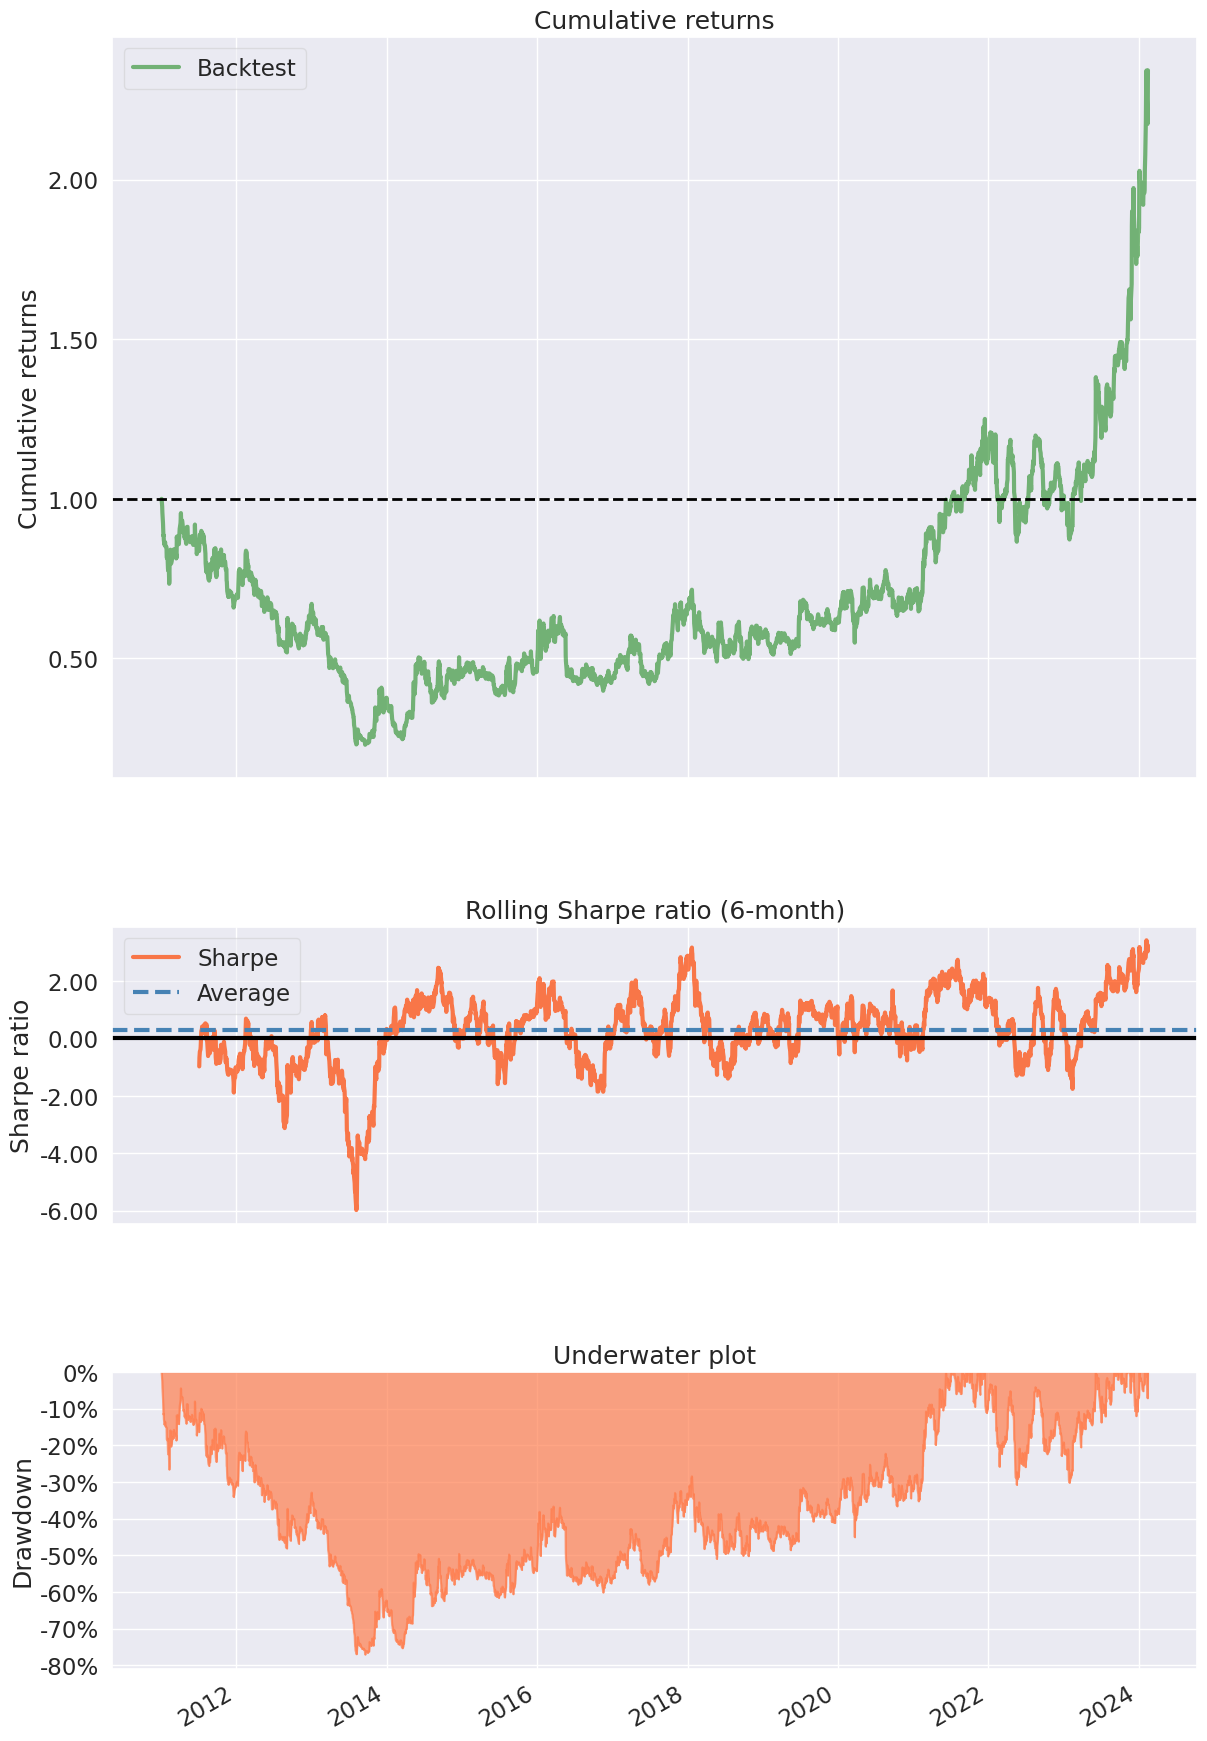

In [16]:
pf.create_simple_tear_sheet(df['bnh_returns'])


Start date,2011-01-03
End date,2024-02-15
Total months,154
,Backtest
Annual return,4.9%
Cumulative returns,84.8%
Annual volatility,28.3%
Sharpe ratio,0.31
Calmar ratio,0.09
Stability,0.01
Max drawdown,-52.7%


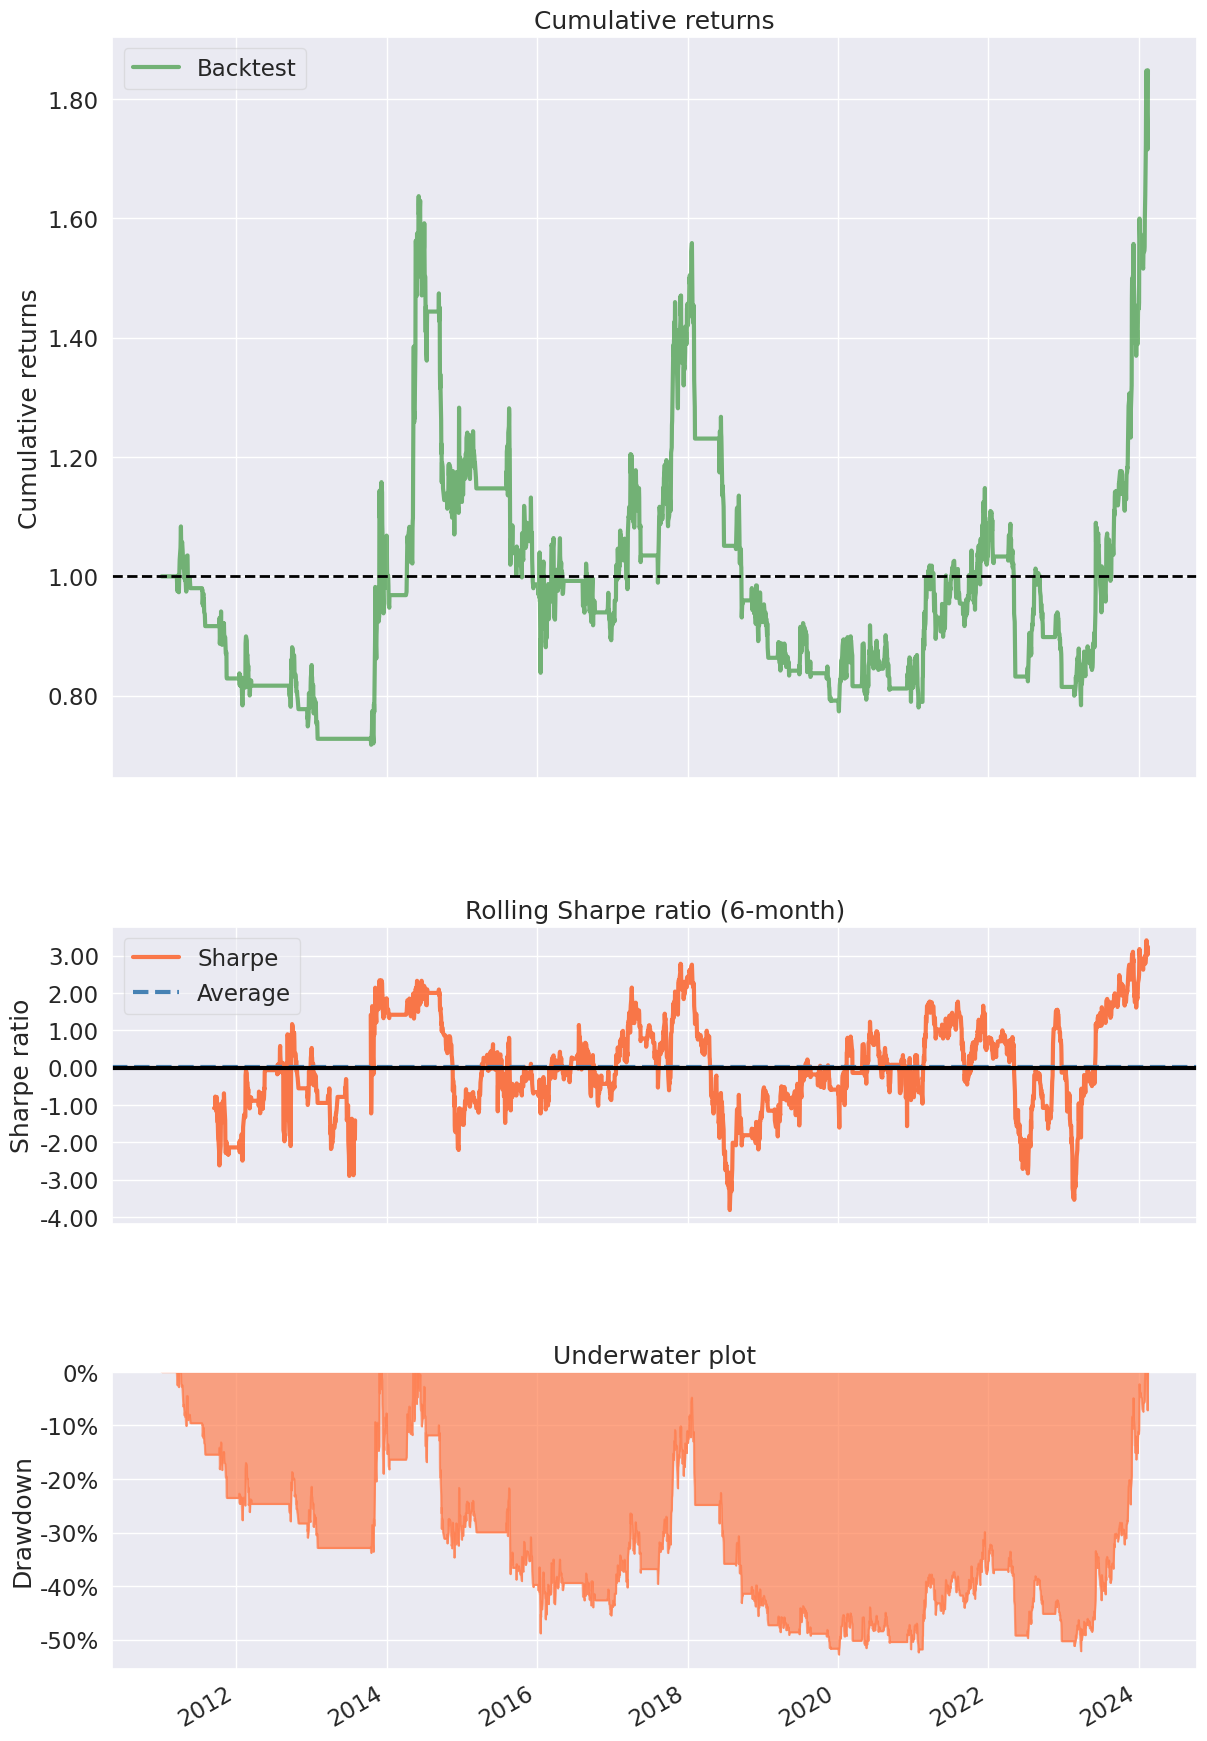

In [17]:
pf.create_simple_tear_sheet(df['sma_strategy_returns'])

Start date,2011-01-03
End date,2024-02-15
Total months,154
,Backtest
Annual return,6.3%
Cumulative returns,120.2%
Annual volatility,28.8%
Sharpe ratio,0.36
Calmar ratio,0.14
Stability,0.34
Max drawdown,-44.2%


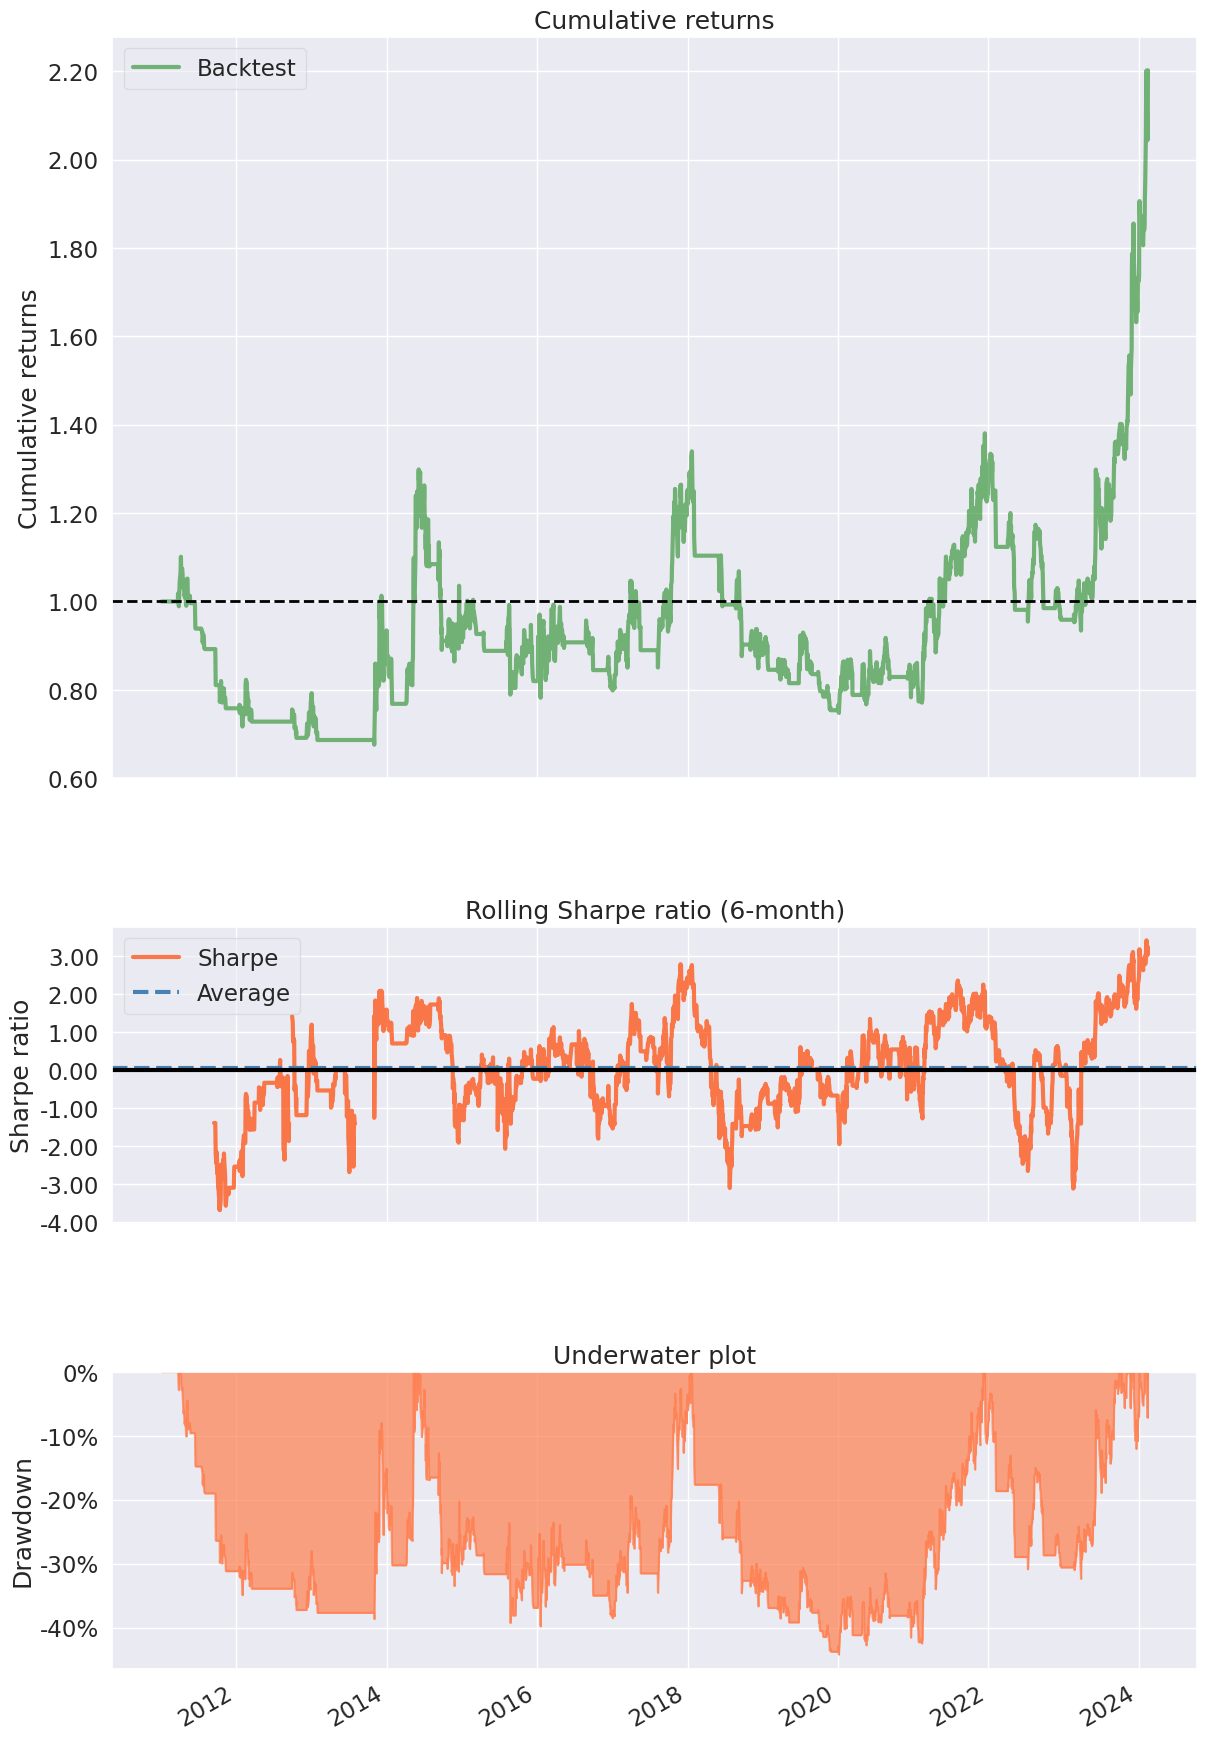

In [18]:
pf.create_simple_tear_sheet(df['ema_strategy_returns'])

In [19]:
np.mean(df[df['sma_position']==1]['sma_strategy_returns'])

0.0006282112907258339

In [20]:
# Parameter space for short and long windows
short_windows = range(10, 51, 5)  # e.g., 10, 15, 20,...50 (9 possible values)
long_windows = range(50, 251, 10)  # e.g., 50, 60,...250 (41 possible values)




In [21]:
# Store results
from scipy.stats import norm
results = []

for short_window in short_windows:
    for long_window in long_windows:
        # Ensure short window is always less than long window
        if short_window >= long_window:
            continue

        # downloading historical necessary data for backtesting and analysis
        _start = dt.date(2011,1,1)
        _end = dt.date.today()
        ticker = 'TORNTPOWER.NS'
        df = yf.download(ticker, start = _start, end = _end)

        # Calculate Moving Averages
        df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
        df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

        # Generate trading signals
        df['Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, np.nan)
        df['Signal']= np.where(df['Short_MA'] < df['Long_MA'], 0, df['Signal'])
        df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

        # Calculate daily returns
        df['Return'] = np.log(df['Close'] / df['Close'].shift(1)) * df['position'].shift(1)
        df = df[df['position']==1]
        df.dropna(inplace=True)

        # Metrics calculation
        annual_return = np.mean(df['Return']) * 252
        annual_volatility = np.std(df['Return']) * np.sqrt(252)
        risk_free_rate = 0.067188
        sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility

        # Max drawdown
        rolling_max = df['Close'].cummax()
        daily_drawdown = df['Close'] / rolling_max - 1.0
        max_drawdown = daily_drawdown.cummin().min()

        # Calmar ratio
        calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)


        # Daily value at risk
        daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))

        # Sortino Ratio
        negative_std = np.std(df['Return'][df['Return'] < 0])
        sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))

        # Omega Ratio
        positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
        negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
        omega_ratio = positive_returns_sum / abs(negative_returns_sum)

        # Tail Ratio
        #tail_ratio = abs(np.percentile(df['Return'], 95)) / abs(np.percentile(df['Return'], 5))

        results.append((short_window, long_window, annual_return, annual_volatility, sharpe_ratio, max_drawdown, calmar_ratio, daily_var, sortino_ratio, omega_ratio))

# Create DataFrame from results and print the best parameter combinations for each metric
df_results = pd.DataFrame(results, columns=['Short_Window', 'Long_Window', 'Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio'])

metrics = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio']
for metric in metrics:
    if metric in ['Annual_Volatility', 'Max_Drawdown', 'Daily_VaR']:
        best_row = df_results.loc[df_results[metric].idxmin()]
    else:
        best_row = df_results.loc[df_results[metric].idxmax()]

    print(f"Best parameters for {metric}: Short_Window = {best_row['Short_Window']}, Long_Window = {best_row['Long_Window']}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Best parameters for Annual_Return: Short_Window = 10.0, Long_Window = 50.0
Best parameters for Annual_Volatility: Short_Window = 50.0, Long_Window = 170.0
Best parameters for Sharpe_Ratio: Short_Window = 10.0, Long_Window = 50.0
Best parameters for Max_Drawdown: Short_Window = 10.0, Long_Window = 50.0
Best parameters for Calmar_Ratio: Short_Window = 45.0, Long_Window = 250.0
Best parameters for Daily_VaR: Short_Window = 50.0, Long_Window = 170.0
Best parameters for Sortino_Ratio: Short_Window = 10.0, Long_Window = 50.0
Best parameters for Omega_Ratio: Short_Window = 10.0, Long_Window = 50.0


In [22]:
#results

## Donchian Channel Trend Following strategy

In [23]:
# Calculate the Donchian Channel Values

# Get historical stock data
df = yf.download(ticker, start=_start, end=_end)

[*********************100%%**********************]  1 of 1 completed


In [24]:
# Define the Donchian Channel window size
channel_window = 5

In [25]:
# Calculate the Donchian Channels
high = df['High'].rolling(window=channel_window).max()
low = df['Low'].rolling(window=channel_window).min()
upper_channel = high.shift(1)
lower_channel = low.shift(1)


<Axes: xlabel='Date'>

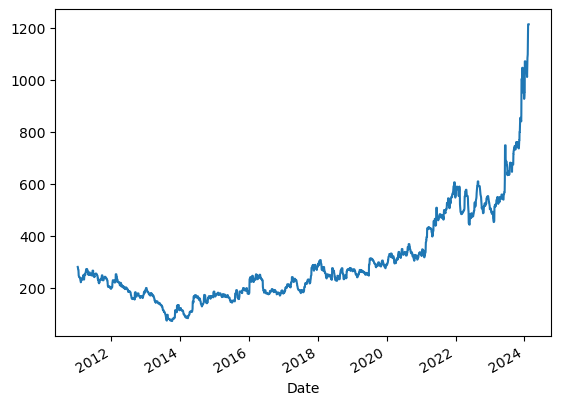

In [26]:
upper_channel.plot()

<Axes: xlabel='Date'>

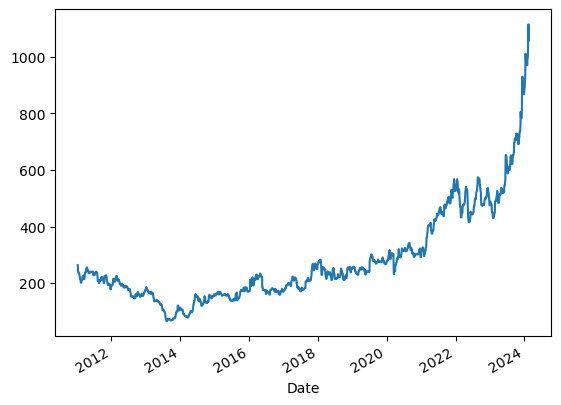

In [27]:
lower_channel.plot()

In [28]:
# Generate trading signals
df['Signal'] = np.where(df['Close'] > upper_channel, 1, np.nan)
df['Signal']= np.where(df['Close'] < lower_channel, 0, df['Signal'])
df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

In [29]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Signal,position
count,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3.236000e+03,673.000000,3231.000000
mean,291.007988,296.290977,286.205485,290.858823,260.916171,8.095274e+05,0.454681,0.481275
std,174.373149,177.743368,171.760899,174.787912,179.911403,1.109258e+06,0.498312,0.499727
min,68.199997,68.949997,66.599998,68.150002,55.392170,0.000000e+00,0.000000,0.000000
25%,175.149994,178.612495,172.787502,175.000000,144.672546,2.033842e+05,0.000000,0.000000
50%,235.825005,240.349998,231.000000,235.250000,192.220955,5.232660e+05,0.000000,0.000000
75%,327.725006,332.550003,323.212502,326.775009,299.085190,1.006879e+06,1.000000,1.000000
max,1175.000000,1236.949951,1142.300049,1208.449951,1196.449951,1.566148e+07,1.000000,1.000000


In [30]:
# Calculate daily returns
df['BH_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Return'] = np.log(df['Close'] / df['Close'].shift(1)) * df['position'].shift(1)


Buy and hold returns: 1.4759685001068672
Donchian_Strategy returns: 1.0861805895521564


<Axes: xlabel='Date'>

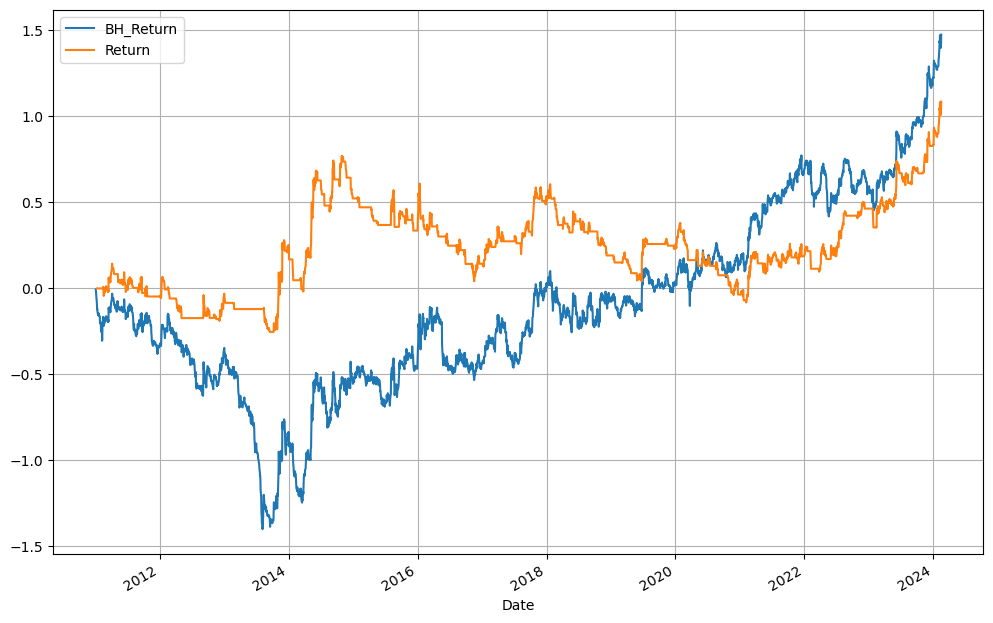

In [31]:
# comparing buy & hold strategy / Donchian_Strategy returns strategy
print("Buy and hold returns:",df['BH_Return'].cumsum()[-1])
print("Donchian_Strategy returns:",df['Return'].cumsum()[-1])

# plotting strategy historical performance over time
df[['BH_Return','Return']].cumsum().plot(grid=True, figsize=(12, 8))

In [32]:
df = df[df['position']==1]
#df.dropna(inplace=True)

In [33]:
# Metrics calculation
annual_return = np.mean(df['Return']) * 252
annual_volatility = np.std(df['Return']) * np.sqrt(252)
risk_free_rate = 0.067487
sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility
print(annual_return)
print(annual_volatility)
print(sharpe_ratio)

0.6383651774340895
0.365954276821594
1.5599713231726973


In [34]:
# Max drawdown
rolling_max = df['Close'].cummax()
daily_drawdown = df['Close'] / rolling_max - 1.0
max_drawdown = daily_drawdown.cummin().min()
np.abs(max_drawdown)

0.7273745112005601

<Axes: xlabel='Date'>

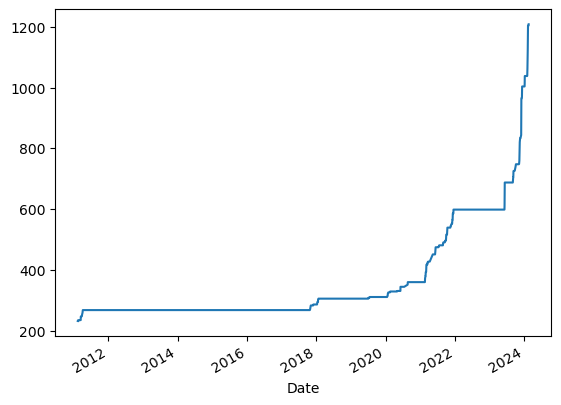

In [35]:
rolling_max.plot()

In [36]:
# Calmar ratio
calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)
calmar_ratio

0.7848476522662758

In [37]:
# Daily value at risk
daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))
daily_var

0.04045192778547864

In [38]:
# Sortino Ratio
negative_std = np.std(df['Return'][df['Return'] < 0]) # Standard Deviation of the returns on the days where there was a negative return
sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))
sortino_ratio

3.06245419891216

In [39]:
# Omega Ratio
positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
omega_ratio = positive_returns_sum / abs(negative_returns_sum)
omega_ratio

1.4034304673300793

In [40]:
# Tail Ratio
tail_ratio = abs(np.percentile(df['Return'], 95)) / abs(np.percentile(df['Return'], 5))

tail_ratio

1.4948410826809644

In [41]:
# Parameter space for different windows
windows = range(5, 31, 1)  # e.g., 5,6,7,...30 (26 possible values)
# Store results
from scipy.stats import norm
results = []


for window in windows:

  # downloading historical necessary data for backtesting and analysis
  _start = dt.date(2011,1,1)
  _end = dt.date.today()
  ticker = 'TORNTPOWER.NS'
  df = yf.download(ticker, start = _start, end = _end)

  # Calculate the Donchian Channels
  high = df['High'].rolling(window=window).max()
  low = df['Low'].rolling(window=window).min()
  upper_channel = high.shift(1)
  lower_channel = low.shift(1)

  # Generate trading signals
  df['Signal'] = np.where(df['Close'] > upper_channel, 1, np.nan)
  df['Signal']= np.where(df['Close'] < lower_channel, 0, df['Signal'])
  df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

  # Calculate daily returns
  df['Return'] = np.log(df['Close'] / df['Close'].shift(1)) * df['position'].shift(1)
  df = df[df['position']==1]

  # Metrics calculation
  annual_return = np.mean(df['Return']) * 252
  annual_volatility = np.std(df['Return']) * np.sqrt(252)
  risk_free_rate = 0.067487
  sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility

  # Max drawdown
  rolling_max = df['Close'].cummax()
  daily_drawdown = df['Close'] / rolling_max - 1.0
  max_drawdown = daily_drawdown.cummin().min()

  # Calmar ratio
  calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)


  # Daily value at risk
  daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))

  # Sortino Ratio
  negative_std = np.std(df['Return'][df['Return'] < 0])
  sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))

  # Omega Ratio
  positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
  negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
  omega_ratio = positive_returns_sum / abs(negative_returns_sum)

  # Tail Ratio
  tail_ratio = abs(np.percentile(df['Return'], 95)) / abs(np.percentile(df['Return'], 5))

  results.append((window, annual_return, annual_volatility, sharpe_ratio, max_drawdown, calmar_ratio, daily_var, sortino_ratio, omega_ratio, tail_ratio))

# Create DataFrame from results and print the best parameter combinations for each metric
df_results = pd.DataFrame(results, columns=['Window', 'Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio', 'tail_ratio'])

metrics = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio','tail_ratio']
for metric in metrics:
    if metric in ['Annual_Volatility', 'Max_Drawdown', 'Daily_VaR']:
        best_row = df_results.loc[df_results[metric].idxmin()]
    else:
        best_row = df_results.loc[df_results[metric].idxmax()]

    print(f"Best parameters for {metric}: Window = {best_row['Window']}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Best parameters for Annual_Return: Window = 5.0
Best parameters for Annual_Volatility: Window = 6.0
Best parameters for Sharpe_Ratio: Window = 5.0
Best parameters for Max_Drawdown: Window = 5.0
Best parameters for Calmar_Ratio: Window = 5.0
Best parameters for Daily_VaR: Window = 9.0
Best parameters for Sortino_Ratio: Window = 5.0
Best parameters for Omega_Ratio: Window = 5.0
Best parameters for tail_ratio: Window = 5.0


In [42]:
#np.round(results,4)

## Bollinger Bands Breakout signals strategy

In [43]:
# Calculate the Bollinger Bands Breakout signals

# Get historical stock data
df = yf.download(ticker, start=_start, end=_end)

[*********************100%%**********************]  1 of 1 completed


In [44]:
# Define the Bollinger Band Parameters
n = 10 # period for moving averages
multiplier_L = 1
multiplier_R = 1.25

In [45]:
# Calculate the Bollinger Bands
bollinger_mean = df['Adj Close'].rolling(window=n).mean()
bollinger_sd = df['Adj Close'].rolling(window=n).std()
df['Bollinger High'] = bollinger_mean + multiplier_R * bollinger_sd
df['Bollinger Low'] = bollinger_mean - multiplier_L * bollinger_sd


In [46]:
# Generate trading signals breakout str
df['Signal'] = np.where(df['Close'] >df['Bollinger High'], 1, np.nan)
df['Signal']= np.where(df['Close'] < df['Bollinger Low'], 0, df['Signal'])
df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

In [47]:
# Calculate daily returns
df['BH_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Return'] = np.log(df['Close'] / df['Close'].shift(1)) * df['position'].shift(1)


Buy and hold returns: 1.4759685001068672
Bollinger Bands Breakout Strategy returns: 1.5579122238760712


<Axes: xlabel='Date'>

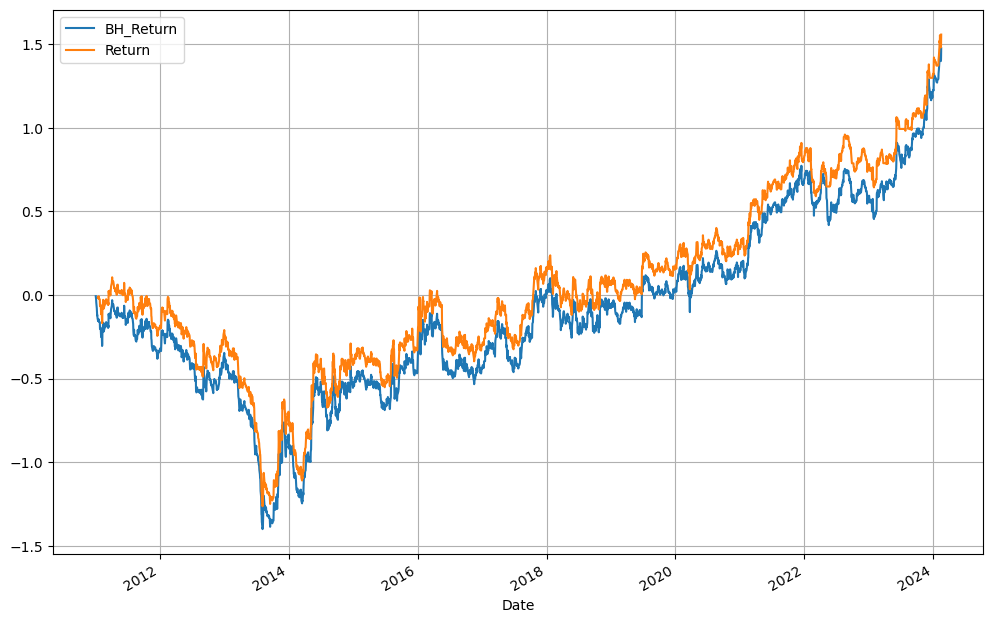

In [48]:
# comparing buy & hold strategy / MA crosover strategy
print("Buy and hold returns:",df['BH_Return'].cumsum()[-1])
print("Bollinger Bands Breakout Strategy returns:",df['Return'].cumsum()[-1])

# plotting strategy historical performance over time
df[['BH_Return','Return']].cumsum().plot(grid=True, figsize=(12, 8))

In [49]:
df = df[df['position']==1]
#df.dropna(inplace=True)

In [50]:
# Metrics calculation
annual_return = np.mean(df['Return']) * 252
annual_volatility = np.std(df['Return']) * np.sqrt(252)
risk_free_rate = 0.067188
sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility
print(annual_return)
print(annual_volatility)
print(sharpe_ratio)

0.15029548257261352
0.3719120681967717
0.22346003176386015


In [51]:
# Max drawdown
rolling_max = df['Close'].cummax()
daily_drawdown = df['Close'] / rolling_max - 1.0
max_drawdown = daily_drawdown.cummin().min()
max_drawdown

-0.7456615099042321

In [52]:
# Calmar ratio
calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)
calmar_ratio

0.11145470360041422

In [53]:
# Daily value at risk
daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))
daily_var

0.03913246602583036

In [54]:
# Sortino Ratio
negative_std = np.std(df['Return'][df['Return'] < 0])
sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))
sortino_ratio

0.36666602492428463

In [55]:
# Omega Ratio
positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
omega_ratio = positive_returns_sum / abs(negative_returns_sum)
omega_ratio

1.077135431495388

In [56]:
# Tail Ratio
tail_ratio = abs(np.percentile(df['Return'].dropna(), 95)) / abs(np.percentile(df['Return'].dropna(), 5))

tail_ratio

1.2289353315289027

In [57]:
# Parameter Optimization
windows = range(10,31, 2)  # e.g., 10, 12, 14,...30 (11 possible values)
multiplier_L = np.arange(1.0,3.1,0.25) #(9 values)
multiplier_R = np.arange(1.0,3.1,0.25) #(9 values)
# Store results
from scipy.stats import norm
results = []


for window in windows:
  for mul_L in multiplier_L:
    for mul_R in multiplier_R:
      # downloading historical necessary data for backtesting and analysis
      _start = dt.date(2011,1,1)
      _end = dt.date.today()
      ticker = 'TORNTPOWER.NS'
      df = yf.download(ticker, start = _start, end = _end)


      # Calculate the Bollinger Bands
      bollinger_mean = df['Close'].rolling(window=window).mean().shift(1)
      bollinger_sd = df['Close'].rolling(window=window).std().shift(1)
      df['Bollinger High'] = bollinger_mean + mul_R * bollinger_sd
      df['Bollinger Low'] = bollinger_mean - mul_L * bollinger_sd

      # Generate trading signals
      df['Signal'] = np.where(df['Close'] > df['Bollinger High'], 1, np.nan)
      df['Signal']= np.where(df['Close'] < df['Bollinger Low'], 0, df['Signal'])
      df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

      # Calculate daily returns
      df['Return'] = np.log(df['Close'] / df['Close'].shift(1)) * df['position'].shift(1)
      df = df[df['position']==1]

      # Metrics calculation
      annual_return = np.mean(df['Return']) * 252
      annual_volatility = np.std(df['Return']) * np.sqrt(252)
      risk_free_rate = 0.067487
      sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility

      # Max drawdown
      rolling_max = df['Close'].cummax()
      daily_drawdown = df['Close'] / rolling_max - 1.0
      max_drawdown = daily_drawdown.cummin().min()

      # Calmar ratio
      calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)


      # Daily value at risk
      daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))

      # Sortino Ratio
      negative_std = np.std(df['Return'][df['Return'] < 0])
      sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))

      # Omega Ratio
      positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
      negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
      omega_ratio = positive_returns_sum / abs(negative_returns_sum)

      # Tail Ratio
      tail_ratio = abs(np.percentile(df['Return'], 95)) / abs(np.percentile(df['Return'], 5))

      results.append((window, mul_L, mul_R,annual_return, annual_volatility, sharpe_ratio, max_drawdown, calmar_ratio, daily_var, sortino_ratio, omega_ratio, tail_ratio))

# Create DataFrame from results and print the best parameter combinations for each metric
df_results = pd.DataFrame(results, columns=['Window', 'multiplier_L','multiplier_R', 'Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio', 'tail_ratio'])
# pandas.DataFrame.idxmin/max - Return index of the minimum/max best parameter 
metrics = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio','tail_ratio']
for metric in metrics:
    if metric in ['Annual_Volatility', 'Max_Drawdown', 'Daily_VaR']:
        best_row = df_results.loc[df_results[metric].idxmin()]
    else:
        best_row = df_results.loc[df_results[metric].idxmax()]

    print(f"Best parameters for {metric}: Window = {best_row['Window']}, multiplier_L = {best_row['multiplier_L']}, multiplier_R = {best_row['multiplier_R']} ")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Best parameters for Annual_Return: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.25 
Best parameters for Annual_Volatility: Window = 12.0, multiplier_L = 2.75, multiplier_R = 1.0 
Best parameters for Sharpe_Ratio: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.25 
Best parameters for Max_Drawdown: Window = 10.0, multiplier_L = 2.75, multiplier_R = 1.0 
Best parameters for Calmar_Ratio: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.25 
Best parameters for Daily_VaR: Window = 14.0, multiplier_L = 2.75, multiplier_R = 1.0 
Best parameters for Sortino_Ratio: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.25 
Best parameters for Omega_Ratio: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.25 
Best parameters for tail_ratio: Window = 10.0, multiplier_L = 1.25, multiplier_R = 3.0 


In [58]:
#atr_multiplier = 1.5
# Volatility (ATR) Breakout signals
# atr = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], n=n).average_true_range()
#df['Upper ATR'] = df['Close'] + atr_multiplier * atr
# df['Lower ATR'] = df['Close'] - atr_multiplier * atr

# **Trend Trading Startegies**

# **Mean Reversion Trading Strategies**

## Bollinger Bands Mean Reversion strategy

In [59]:
# Calculate the Bollinger Bands Mean Reversion signals

# Get historical stock data
df = yf.download(ticker, start=_start, end=_end)

[*********************100%%**********************]  1 of 1 completed


In [60]:
df.dropna(inplace = True)

In [61]:
# Define the Bollinger Band Parameters
n = 10 # period for moving averages
multiplier_L = 2
multiplier_R = 2

In [62]:
# Calculate the Bollinger Bands
bollinger_mean = df['Adj Close'].rolling(window=n).mean()
bollinger_sd = df['Adj Close'].rolling(window=n).std()
df['Bollinger High'] = bollinger_mean + multiplier_R * bollinger_sd
df['Bollinger Low'] = bollinger_mean - multiplier_L * bollinger_sd


In [63]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Bollinger High,Bollinger Low
Date,,,,,,,,
2024-02-09,1140.000000,1191.699951,1115.250000,1173.449951,1161.797485,1223641,1232.396621,942.143467
2024-02-12,1172.699951,1194.650024,1117.650024,1130.500000,1119.274048,364493,1229.970580,969.647987
2024-02-13,1132.949951,1147.750000,1108.949951,1119.349976,1108.234741,454176,1219.562127,1002.115193
2024-02-14,1117.000000,1162.949951,1056.949951,1130.800049,1119.571167,809686,1212.389494,1027.267513
2024-02-15,1134.000000,1236.949951,1134.000000,1208.449951,1196.449951,2399731,1221.153157,1049.542547


In [64]:
# Generate trading signals
df['Signal'] = np.where(df['Adj Close'] <df['Bollinger Low'], 1, np.nan)
df['Signal']= np.where(df['Adj Close'] > df['Bollinger High'], 0, df['Signal'])
df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

In [65]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Bollinger High,Bollinger Low,Signal,position
count,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3.236000e+03,3227.000000,3227.000000,226.000000,3218.000000
mean,291.007988,296.290977,286.205485,290.858823,260.916171,8.095274e+05,273.006913,246.510688,0.389381,0.397763
std,174.373149,177.743368,171.760899,174.787912,179.911403,1.109258e+06,186.624681,167.660482,0.488692,0.489512
min,68.199997,68.949997,66.599998,68.150002,55.392170,0.000000e+00,58.811475,49.576759,0.000000,0.000000
25%,175.149994,178.612495,172.787502,175.000000,144.672546,2.033842e+05,149.932467,138.386787,0.000000,0.000000
50%,235.825005,240.349998,231.000000,235.250000,192.220955,5.232660e+05,203.018265,183.317723,0.000000,0.000000
75%,327.725006,332.550003,323.212502,326.775009,299.085190,1.006879e+06,311.867163,288.015476,1.000000,1.000000
max,1175.000000,1236.949951,1142.300049,1208.449951,1196.449951,1.566148e+07,1232.396621,1049.542547,1.000000,1.000000


In [66]:
# Calculate daily returns
df['BH_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
df['Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) * df['position'].shift(1)


Buy and hold returns: 1.7318342896460492
Bollinger Bands Breakout Strategy returns: 0.48637578779344665


<Axes: xlabel='Date'>

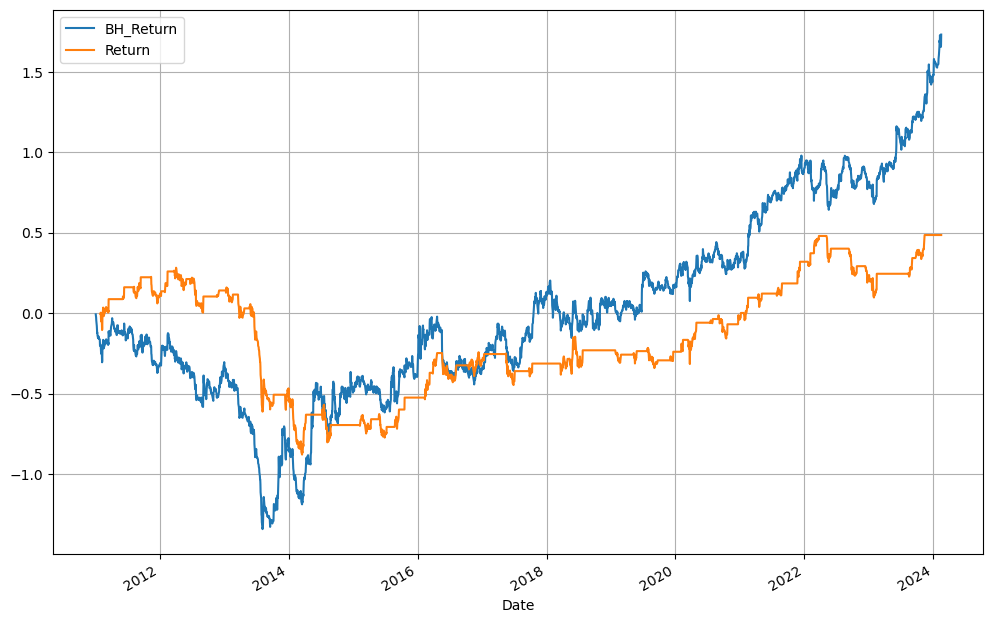

In [67]:
# comparing buy & hold strategy / MA crosover strategy
print("Buy and hold returns:",df['BH_Return'].cumsum()[-1])
print("Bollinger Bands Breakout Strategy returns:",df['Return'].cumsum()[-1])

# plotting strategy historical performance over time
df[['BH_Return','Return']].cumsum().plot(grid=True, figsize=(12, 8))

In [68]:
df = df[df['position']==1]
#df.dropna(inplace=True)

In [69]:
# Metrics calculation
annual_return = np.mean(df['Return']) * 252
annual_volatility = np.std(df['Return']) * np.sqrt(252)
risk_free_rate = 0.067188
sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility
print(annual_return)
print(annual_volatility)
print(sharpe_ratio)

-0.3006407818211405
0.3170280021150373
-1.1602406707520732


In [70]:
# Max drawdown
rolling_max = df['Adj Close'].cummax()
daily_drawdown = df['Adj Close'] / rolling_max - 1.0
max_drawdown = daily_drawdown.cummin().min()
max_drawdown

-0.7049369348412173

In [71]:
# Calmar ratio
calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)
calmar_ratio

-0.5217896291729865

In [72]:
# Daily value at risk
daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))
daily_var

0.03165616687098196

In [73]:
# Sortino Ratio
negative_std = np.std(df['Return'][df['Return'] < 0])
sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))
sortino_ratio

-1.6887724332806555

In [74]:
# Omega Ratio
positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
omega_ratio = positive_returns_sum / abs(negative_returns_sum)
omega_ratio

0.8441850607191416

In [75]:
# Tail Ratio
tail_ratio = abs(np.percentile(df['Return'].dropna(), 95)) / abs(np.percentile(df['Return'].dropna(), 5))

tail_ratio

0.9511269862799872

In [76]:
# Parameter Optimization
windows = range(10,31, 2)  # e.g., 10, 12, 14,...30 (11 possible values)
multiplier_L = np.arange(1.0,3.1,0.25) #(9 values)
multiplier_R = np.arange(1.0,3.1,0.25) #(9 values)
# Store results
from scipy.stats import norm
results = []


for window in windows:
  for mul_L in multiplier_L:
    for mul_R in multiplier_R:
      # downloading historical necessary data for backtesting and analysis
      _start = dt.date(2011,1,1)
      _end = dt.date.today()
      ticker = 'TORNTPOWER.NS'
      df = yf.download(ticker, start = _start, end = _end)


      # Calculate the Bollinger Bands
      bollinger_mean = df['Adj Close'].rolling(window=window).mean().shift(1)
      bollinger_sd = df['Adj Close'].rolling(window=window).std().shift(1)
      df['Bollinger High'] = bollinger_mean + mul_R * bollinger_sd
      df['Bollinger Low'] = bollinger_mean - mul_L * bollinger_sd

      # Generate trading signals
      df['Signal'] = np.where(df['Adj Close'] < df['Bollinger Low'], 1, np.nan)
      df['Signal']= np.where(df['Adj Close'] > df['Bollinger High'], 0, df['Signal'])
      df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')
      # Calculate daily returns
      df['Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) * df['position'].shift(1)
      df = df[df['position']==1]

      # Metrics calculation
      annual_return = np.mean(df['Return']) * 252
      annual_volatility = np.std(df['Return']) * np.sqrt(252)
      risk_free_rate = 0.067487
      sharpe_ratio = (annual_return- risk_free_rate)/ annual_volatility

      # Max drawdown
      rolling_max = df['Adj Close'].cummax()
      daily_drawdown = df['Adj Close'] / rolling_max - 1.0
      max_drawdown = daily_drawdown.cummin().min()

      # Calmar ratio
      calmar_ratio = (annual_return -risk_free_rate)/abs(max_drawdown)


      # Daily value at risk
      daily_var = norm.ppf(1-0.05, np.mean(df['Return']), np.std(df['Return']))

      # Sortino Ratio
      negative_std = np.std(df['Return'][df['Return'] < 0])
      sortino_ratio = (annual_return -risk_free_rate)/(negative_std * np.sqrt(252))

      # Omega Ratio
      positive_returns_sum = np.sum(df['Return'][df['Return'] > 0])
      negative_returns_sum = np.sum(df['Return'][df['Return'] < 0])
      omega_ratio = positive_returns_sum / abs(negative_returns_sum)

      # Tail Ratio
      tail_ratio = abs(np.percentile(df['Return'].dropna(), 95)) / abs(np.percentile(df['Return'].dropna(), 5))

      results.append((window, mul_L, mul_R,annual_return, annual_volatility, sharpe_ratio, max_drawdown, calmar_ratio, daily_var, sortino_ratio, omega_ratio, tail_ratio))

# Create DataFrame from results and print the best parameter combinations for each metric
df_results = pd.DataFrame(results, columns=['Window', 'multiplier_L','multiplier_R', 'Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio', 'tail_ratio'])

metrics = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 'Calmar_Ratio', 'Daily_VaR', 'Sortino_Ratio', 'Omega_Ratio','tail_ratio']
for metric in metrics:
    if metric in ['Annual_Volatility', 'Max_Drawdown', 'Daily_VaR']:
        best_row = df_results.loc[df_results[metric].idxmin()]
    else:
        best_row = df_results.loc[df_results[metric].idxmax()]

    print(f"Best parameters for {metric}: Window = {best_row['Window']}, multiplier_L = {best_row['multiplier_L']}, multiplier_R = {best_row['multiplier_R']} ")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Best parameters for Annual_Return: Window = 28.0, multiplier_L = 1.0, multiplier_R = 2.75 
Best parameters for Annual_Volatility: Window = 10.0, multiplier_L = 1.25, multiplier_R = 1.0 
Best parameters for Sharpe_Ratio: Window = 28.0, multiplier_L = 1.0, multiplier_R = 3.0 
Best parameters for Max_Drawdown: Window = 26.0, multiplier_L = 1.0, multiplier_R = 2.75 
Best parameters for Calmar_Ratio: Window = 28.0, multiplier_L = 1.0, multiplier_R = 2.75 
Best parameters for Daily_VaR: Window = 10.0, multiplier_L = 1.0, multiplier_R = 1.0 
Best parameters for Sortino_Ratio: Window = 28.0, multiplier_L = 1.0, multiplier_R = 3.0 
Best parameters for Omega_Ratio: Window = 28.0, multiplier_L = 1.0, multiplier_R = 3.0 
Best parameters for tail_ratio: Window = 26.0, multiplier_L = 1.0, multiplier_R = 3.0 


In [77]:
df

,Open,High,Low,Close,Adj Close,Volume,Bollinger High,Bollinger Low,Signal,position,Return
Date,,,,,,,,,,,
2011-06-23,237.000000,237.000000,228.500000,231.100006,178.937637,40331,195.933992,180.100778,1.0,1.0,-0.000000
2011-06-24,234.899994,236.399994,230.000000,232.550003,180.060364,36448,197.083518,178.385536,NaN,1.0,0.006255
2011-06-27,233.000000,240.250000,232.600006,239.149994,185.170609,37959,197.713364,177.221387,NaN,1.0,0.027985
2011-06-28,242.000000,245.199997,235.300003,237.250000,183.699493,54178,197.670608,177.052636,NaN,1.0,-0.007976
2011-06-29,238.000000,240.699997,236.600006,238.399994,184.589920,30783,197.608837,176.738392,NaN,1.0,0.004835
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,530.349976,537.900024,521.500000,535.349976,526.801758,162633,550.910104,504.832068,NaN,1.0,0.009761
2023-05-24,534.950012,555.500000,532.549988,552.900024,544.071533,477060,549.796284,506.864320,NaN,1.0,0.032256
2023-05-25,554.150024,561.000000,543.349976,555.549988,546.679199,418734,550.409018,508.409897,NaN,1.0,0.004781


## **Triple Moving Average Crossover strategy**

In [78]:
short_window = 10
medium_window = 50
long_window = 200

df['Short_MA'] = df['Close'].rolling(window=short_window).mean()
df['Medium_MA'] = df['Close'].rolling(window=medium_window).mean()
df['Long_MA'] = df['Close'].rolling(window=long_window).mean()

df['Signal'] = np.where((df['Short_MA'] > df['Medium_MA']) & (df['Medium_MA'] > df['Long_MA']), 1, np.nan)
df['Signal']= np.where((df['Short_MA'] < df['Medium_MA']) | (df['Medium_MA'] < df['Long_MA']), 0, df['Signal'])
df['position'] = df['Signal'].replace(to_replace=np.nan, method='ffill')

